In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import fetch_data
import numpy as np
import correct_drift
import datetime
from scipy import signal
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick
from ahrs.filters import Mahony

import importlib
importlib.reload(fetch_data)

start_date_str = '2023-08-08'
end_date_str = '2023-08-09'
organization_id = 'hamid'
can_k3y_id = '17700cf8'
imu_k3y_id = '08558cba'

In [2]:
event_dict = fetch_data.get_events(can_k3y_id, organization_id, start_date_str, end_date_str)
can_df = fetch_data.get_can_data(can_k3y_id, organization_id, start_date_str, end_date_str)

In [3]:
raw_acc_df, raw_gyro_df = fetch_data.get_raw_data(imu_k3y_id, organization_id, start_date_str, end_date_str)

In [4]:
k3y_g = 9.87
S3_K3Y_VEH_ROT_MTX = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])

def calculate_rot_matrix(ac_data, gy_data, filter_params):
    madg_filter = Madgwick(acc=ac_data, gyr=gy_data, Dt=(1/filter_params['SR']), gain=filter_params['gain'],
                        q0=filter_params['init_qua'])
    quaternions = madg_filter.Q
    filter_params['init_qua'] = quaternions[-1,:]
    # converting quaternion from scalar first (AHRS library) to scalar last(SciPy)
    quaternions_scipy = np.roll(quaternions, shift=3, axis=1)
    rot_mtxs = R.from_quat(quaternions_scipy).as_matrix()

    return rot_mtxs

def gravity_compensate(ac_batch, gy_batch, madgwick_params, g=k3y_g):
    rotation_mtxs = calculate_rot_matrix(ac_batch, gy_batch, madgwick_params)
    # Rotation matrix is orthogonal, last colum = last row of the inverse
    gravity_components = g * rotation_mtxs[:,-1,:]
    ac_g_compensated = ac_batch - gravity_components

    return ac_g_compensated

def imu_k3y_to_vehicle(ac_batch_np, gy_batch_np, madgwick_params):
    g_removed_ac_np = gravity_compensate(ac_batch_np[:, 1:], gy_batch_np[:, 1:], madgwick_params, g=k3y_g)
    vehicle_ac = np.matmul(S3_K3Y_VEH_ROT_MTX, g_removed_ac_np.T)
    vehicle_ac_np = np.column_stack((ac_batch_np[:,0], vehicle_ac.T))

    vehicle_gy = np.matmul(S3_K3Y_VEH_ROT_MTX, gy_batch_np[:, 1:].T)
    vehicle_gy_np = np.column_stack((gy_batch_np[:,0], vehicle_gy.T))

    return vehicle_ac_np, vehicle_gy_np

In [5]:
timestamp = 'timestamp(epoch in sec)'
madgwick_params = {'SR': 100, 'gain': 0.033, 'init_qua': [0,0,0,1]}

merged_data = pd.merge(raw_acc_df, raw_gyro_df, on=timestamp, how='inner')
raw_acc_np = merged_data[[timestamp, 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)']].to_numpy()
raw_gyro_np = merged_data[[timestamp, 'lr_w(rad/s)', 'bf_w(rad/s)', 'vert_w(rad/s)']].to_numpy()
corrected_acc_np, corrected_gyro_np = imu_k3y_to_vehicle(raw_acc_np, raw_gyro_np, madgwick_params)
corrected_acc_df = pd.DataFrame(corrected_acc_np, columns=[timestamp, 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)'])
corrected_gyro_df = pd.DataFrame(corrected_gyro_np, columns=[timestamp, 'lr_w(rad/s)', 'bf_w(rad/s)', 'vert_w(rad/s)'])

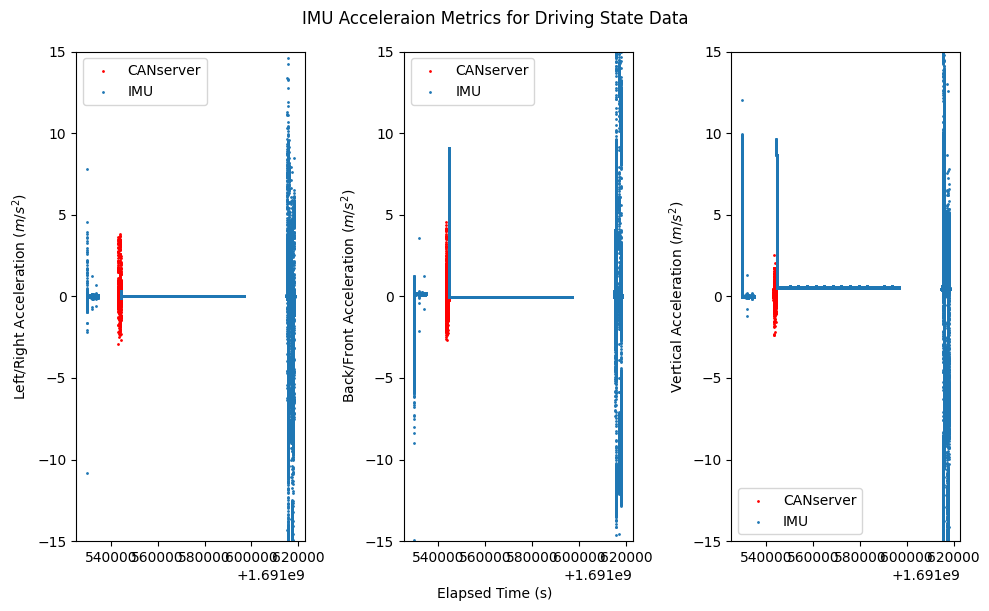

In [6]:
imu_df = corrected_acc_df

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10,6)

ax1.scatter(x=can_df['timestamp'], y=-can_df['lr_acc'], s=1, color='red', label='CANserver')
ax1.scatter(x=imu_df['timestamp(epoch in sec)'], y=imu_df['lr_acc(m/s^2)'], s=1, label='IMU')
ax1.set_ylim(-15,15)

ax2.scatter(x=can_df['timestamp'], y=can_df['bf_acc'], s=1, color='red', label='CANserver')
ax2.scatter(x=imu_df['timestamp(epoch in sec)'], y=imu_df['bf_acc(m/s^2)'], s=1, label='IMU')
ax2.set_ylim(-15,15)

ax3.scatter(x=can_df['timestamp'], y=can_df['vert_acc'], s=1, color='red', label='CANserver')
ax3.scatter(x=imu_df['timestamp(epoch in sec)'], y=imu_df['vert_acc(m/s^2)'], s=1, label='IMU')
ax3.set_ylim(-15,15)

fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

ax1.legend()
ax2.legend()
ax3.legend()
plt.tight_layout()
plt.show()

In [9]:
imu_ss_df = raw_acc_df[raw_acc_df['timestamp(epoch in sec)'] > 560000 + 1.691 * 10**9]

print('left/right acceleration:')
print(f'imu mean: {imu_ss_df["lr_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["lr_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["lr_acc(m/s^2)"].min()}')
print('')
print('back/from acceleration:')
print(f'imu mean: {imu_ss_df["bf_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["bf_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["bf_acc(m/s^2)"].min()}')
print('')
print('vertical acceleration:')
print(f'imu mean: {imu_ss_df["vert_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["vert_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["vert_acc(m/s^2)"].min()}')
print('')
print('normalized acceleration:')
imu_norm = np.sqrt(imu_ss_df['lr_acc(m/s^2)']**2 + imu_ss_df['bf_acc(m/s^2)']**2 + imu_ss_df['vert_acc(m/s^2)']**2)
print(f'imu mean: {imu_norm.mean()}')
print(f'imu max: {imu_norm.max()}')
print(f'imu min: {imu_norm.min()}')

left/right acceleration:
imu mean: 0.18222239745835037
imu max: 0.193220215
imu min: 0.172881245

back/from acceleration:
imu mean: 0.7176078515603745
imu max: 0.7298101
imu min: 0.693319595

vertical acceleration:
imu mean: -10.362163881873997
imu max: -10.343562655
imu min: -10.459614425

normalized acceleration:
imu mean: 10.388581485023431
imu max: 10.484632581478749
imu min: 10.369943529835767


In [11]:
imu_ss_df = raw_gyro_df[raw_gyro_df['timestamp(epoch in sec)'] > 560000 + 1.691 * 10**9]

print('left/right acceleration:')
print(f'imu mean: {imu_ss_df["lr_w(rad/s)"].mean()}')
print(f'imu max: {imu_ss_df["lr_w(rad/s)"].max()}')
print(f'imu min: {imu_ss_df["lr_w(rad/s)"].min()}')
print('')
print('back/from acceleration:')
print(f'imu mean: {imu_ss_df["bf_w(rad/s)"].mean()}')
print(f'imu max: {imu_ss_df["bf_w(rad/s)"].max()}')
print(f'imu min: {imu_ss_df["bf_w(rad/s)"].min()}')
print('')
print('vertical acceleration:')
print(f'imu mean: {imu_ss_df["vert_w(rad/s)"].mean()}')
print(f'imu max: {imu_ss_df["vert_w(rad/s)"].max()}')
print(f'imu min: {imu_ss_df["vert_w(rad/s)"].min()}')
print('')
print('normalized acceleration:')
imu_norm = np.sqrt(imu_ss_df['lr_w(rad/s)']**2 + imu_ss_df['bf_w(rad/s)']**2 + imu_ss_df['vert_w(rad/s)']**2)
print(f'imu mean: {imu_norm.mean()}')
print(f'imu max: {imu_norm.max()}')
print(f'imu min: {imu_norm.min()}')

left/right acceleration:
imu mean: -0.0029017492527488036
imu max: 0.000610864
imu min: -0.005955924

back/from acceleration:
imu mean: 0.0004163803553911853
imu max: 0.00152716
imu min: -0.00076358

vertical acceleration:
imu mean: 0.001983156050469386
imu max: 0.0029016040000000003
imu min: 0.001069012

normalized acceleration:
imu mean: 0.003558053718373888
imu max: 0.006238967289452959
imu min: 0.0017074167862592895
